# SWOT denoising module: description and use

* Emmanuel Cosme, Laura Gómez Navarro, Julien Le Sommer, Nicolas Papadakis, Ananda Pascual, Audrey Monsimer
* March 2018
* describe the denoising methods and show how to call them

## Descriptions

* Input, outputs
* Methods



## 0. Imports, input files, plots

In [1]:
#from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

import SWOTdenoise as swotd
#filedir = '/Users/cosme/data/NATL60/MED-BOX/'
#filename = filedir+'MED_1km_nogap_FMA13_swotFastPhase_BOX_c01_p009.nc'
filedir = '/Users/cosme/data/NATL60/SWOT_fast_sampling_simulation_cycle1_passes/'
filename = filedir+'MED_fastPhase_1km_swotFAST_c01_p009.nc'
filename_den = filedir+'MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc'   # created by the module

###  A function for plots
This function plots a SSH field as read in a SWOT file.
The function calls the fill_nadir_gap function of the SWOTdenoise module, to clearly show the gap. Otherwise, pyplot fills the gap by crudely interpolating the data between the two swaths.

In [2]:
vmin=-0.3
vmax=0.15
def splot(sshin):
    _, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    cs=plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)
    plt.colorbar(cs)

## 1. Call the ```SWOTdenoise``` function
The ```SWOTdenoise``` function can be called by providing the SWOT Netcdf file name only. In this case, the denoised field is returned in another Netcdf file named **foo_denoised.nc** if the input file is **foo.nc**. It is created in the same directory.

In [3]:
swotd.SWOTdenoise(filename)

0.0769230769231
115 0.995326289511
Filtered field in  /Users/cosme/data/NATL60/SWOT_fast_sampling_simulation_cycle1_passes/MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc


The function can also be called by providing the appropriate arrays as keywords arguments: ```ssh, lon, lat, x_ac, time```. In the example below, these arrays are first read in the SWOT file using the ```read_data``` function of the module:

In [4]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
ssh_den = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time)

0.0769230769231
115 0.995326289511


### Plot the initial SSH field, and the denoised field

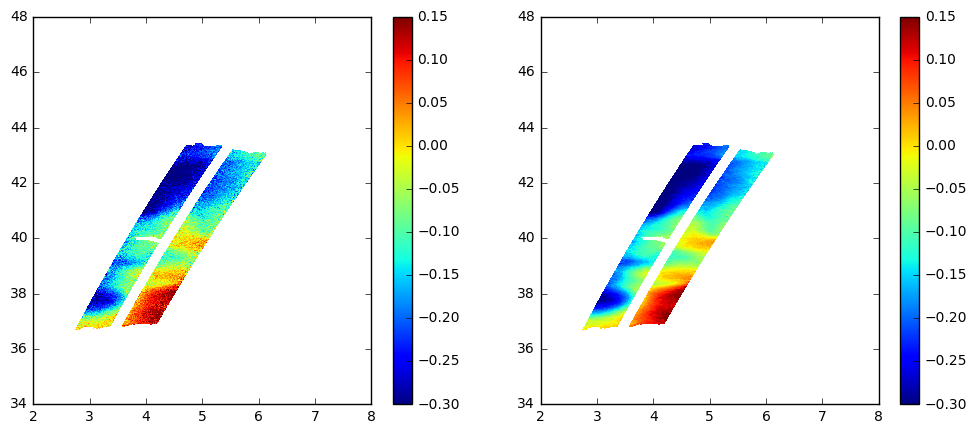

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den)

### For further check, read previously created file and plot SSH:

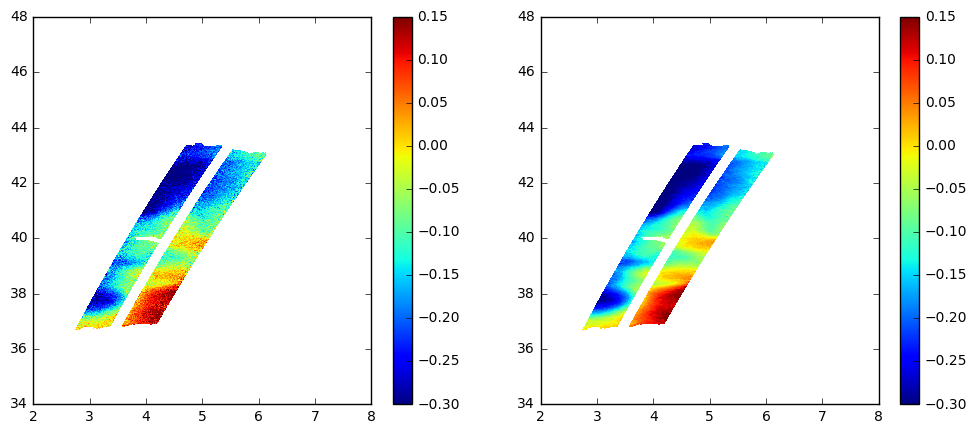

In [6]:
ssh_den2, lon, lat, x_ac, time = swotd.read_data(filename_den, 'SSH', 'lon', 'lat', 'x_ac', 'time')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den2)

## 2. Optional parameters

In addition to the arguments described above, the ```SWOTdenoise``` function takes 5 optional arguments:

- ```method```: ```gaussian```, ```boxcar```, or ```var_reg```;
- ```param```: number for ```gaussian``` and ```boxcar```; 3-entry tuple for ```var_reg```;
- ```itermax```: only for ```var_reg```: maximum number of iterations in the gradient descent algortihm;
- ```epsilon```: only for ```var_reg```: convergence criterium for the gradient descent algortihm;
- ```inpainting```: if ```True```, the nadir gap is inpainted. If ```False```, it is not and the returned SSH array is of the same shape as the original one. If the ```SWOTdenoise``` function is called using arrays (see above description) with ```inpainting=True```, then it returns SSH, lon, and lat arrays. If it is called using arrays with ```inpainting=False```, it returns only SSH, since lon and lat arrays are the same as for the input field.

Without the necessary arguments, denoising is performed using a default method with default parameter(s) identified to be optimal.

## 3. Examples (without inpainting)
Examples below are given using the second method to call the function: giving arrays as arguments. The arrays are first read in the input file using the ```read_data``` function.

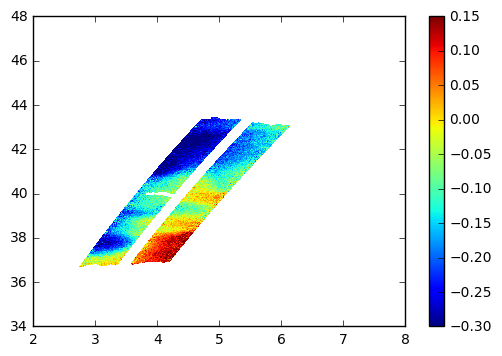

In [7]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
splot(ssh)

### Gaussian filter

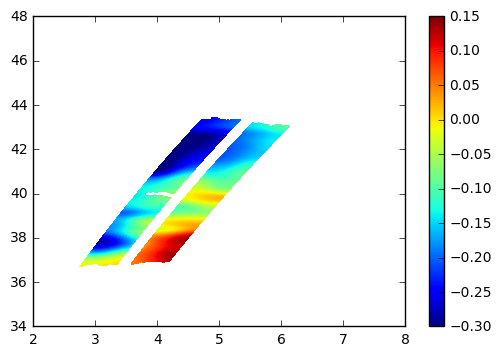

In [8]:
ssh_gau = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='gaussian', param=10.)
splot(ssh_gau)

### Boxcar filter

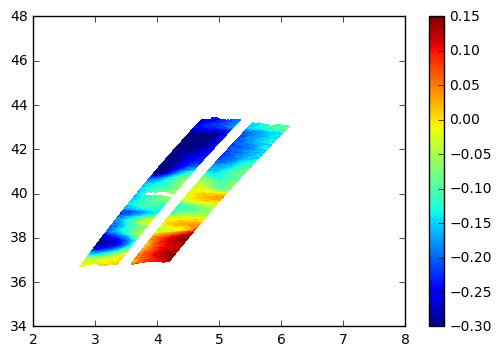

In [9]:
ssh_box = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='boxcar', param=4.)
splot(ssh_box)

### First order (gradients) regularization filter
The function prints the number of iterations of the gradient descent method, and the convergence ratio. The convergence ratio is defined here as the ratio between the norm of the descent increment and the convergence factor (equal to 1e-9 by default). Iterations stops when the convergence ratio is below 1.

0.0123456790123
595 0.990788506445


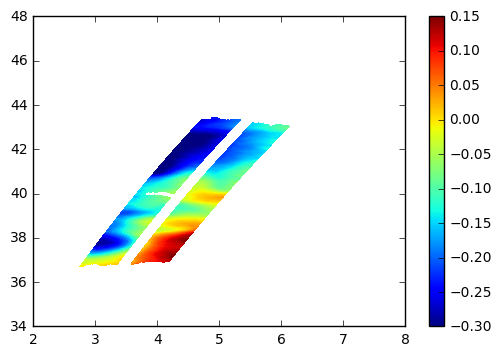

In [10]:
ssh_vr1 = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(10.,0,0) )
splot(ssh_vr1)

### Second order (laplacian) regularization filter

0.0153846153846
495 0.999726762241


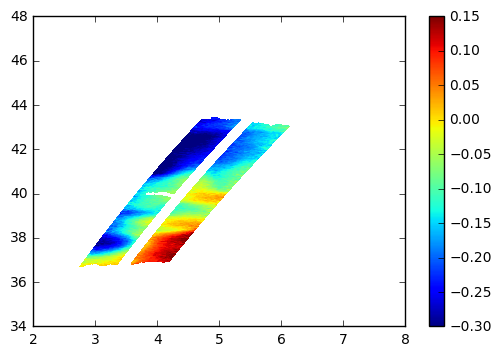

In [11]:
ssh_vr2 = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(0,1,0) )
splot(ssh_vr2)

### Third order (gradient of laplacian) regularization filter

0.00194931773879
4144 0.99923444764


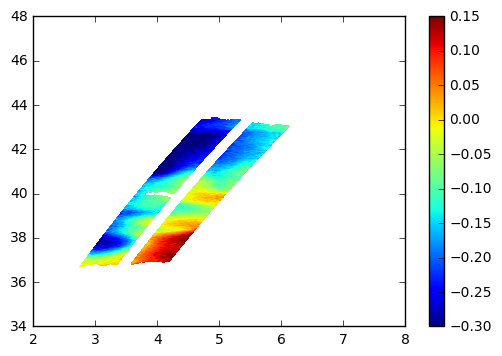

In [12]:
ssh_vr3 = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(0,0,1) )
splot(ssh_vr3)

### Combined orders regularization filter

0.000488042947779
10000 12.0941539939


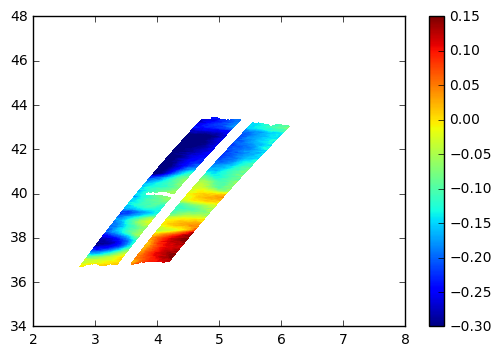

In [13]:
ssh_vr = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(1,2,4) )
splot(ssh_vr)

## 4. Inpainting

* Description...

### Gaussian filter

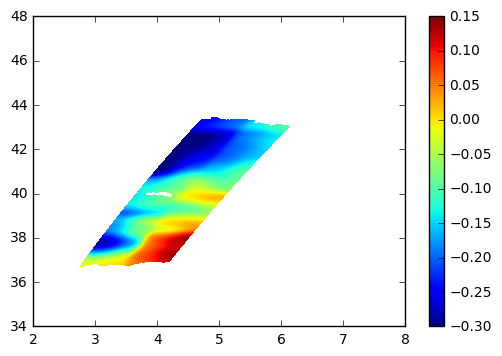

In [14]:
ssh_gau_inp, lon_f, lat_f = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='gaussian', param=10., inpainting=True)
cs=plt.pcolormesh(lon_f, lat_f, ssh_gau_inp, vmin=vmin, vmax=vmax)
plt.colorbar(cs)

### Boxcar filter

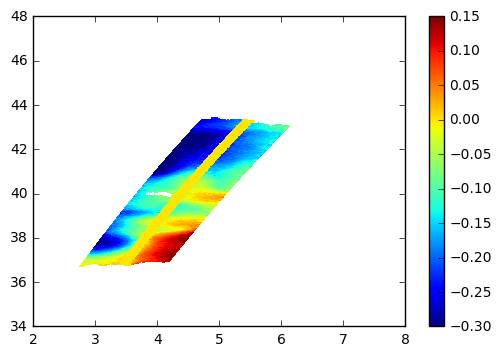

In [15]:
ssh_box_inp, _, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='boxcar', param=4., inpainting=True)
cs=plt.pcolormesh(lon_f, lat_f, ssh_box_inp, vmin=vmin, vmax=vmax)
plt.colorbar(cs)

### Combined orders regularization filter

0.000488042947779
10000 12.0941539939


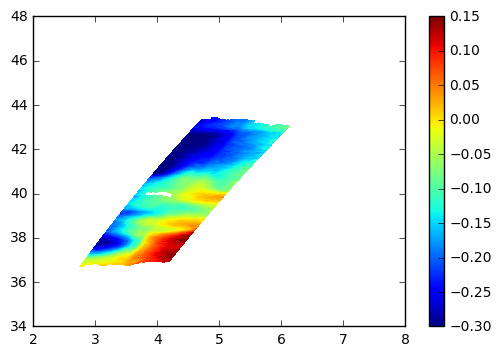

In [16]:
ssh_vr_inp, _, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(1,2,4), inpainting=True )
cs=plt.pcolormesh(lon_f, lat_f, ssh_vr_inp, vmin=vmin, vmax=vmax)
plt.colorbar(cs)

## 5. Test with a descending SWOT pass

In [38]:
filename2 = '/Users/cosme/data/NATL60/SWOT-OSMOSIS-1/swot292-OSMOSIS_c01_p014.nc'
ssh2, lon2, lat2, x_ac2, time2 = swotd.read_data(filename2, 'ssh_obs', 'lon', 'lat', 'x_ac', 'time_sec')
ssh_den2 = swotd.SWOTdenoise(ssh=ssh2, lon=lon2, lat=lat2, x_ac=x_ac2, time=time2, method='var_reg', param=(4,2,1))

0.00194931773879
4475 0.999421954501


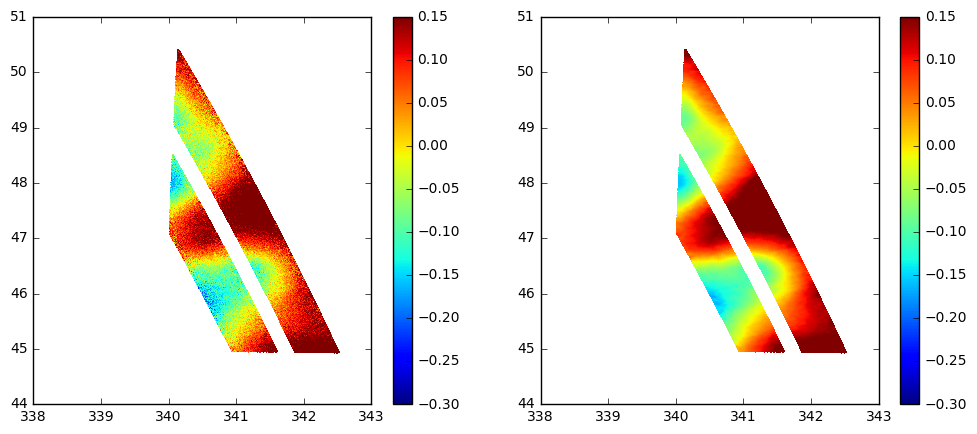

In [39]:
ssh_f2, lon_f2, lat_f2, x_ac_f2 = swotd.fill_nadir_gap(ssh2, lon2, lat2, x_ac2, time2)
ssh_fden2, _, _, _ = swotd.fill_nadir_gap(ssh_den2, lon2, lat2, x_ac2, time2)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cs=plt.pcolormesh(lon_f2, lat_f2, ssh_f2, vmin=vmin, vmax=vmax)
plt.colorbar(cs)
plt.subplot(1,2,2)
cs=plt.pcolormesh(lon_f2, lat_f2, ssh_fden2, vmin=vmin, vmax=vmax)
plt.colorbar(cs)